# Network Science Data - Assignment 2
- Course: PHYS 7332
- Semester: Fall 2024
- Date: October 18, 2024
- Name: Minami Ueda (ueda.m@northeastern.edu)
- Environment: `/work/netsi/ueda.m/conda/netsi`

***
## Setup

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams['text.usetex'] = False 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

***
## Question 2

### Question 2(b): # of nodes and edges

#### Import data

In [4]:
import os
data_path = "data/tsp"
file_list = [ f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) ]

In [5]:
file_list

['berlin52.gml', 'brazil58.gml', 'brg180.gml', 'gr229.gml', 'pr439.gml']

In [6]:
graphs = {}
file_list2 = [] # file_list without gml extension

In [7]:
# Load each gmls using networkx and store it in a dictionary
for f in file_list:
    file_name_without_ext = f.split(".")[0]
    file_list2.append(file_name_without_ext)
    print(file_name_without_ext)
    graphs[file_name_without_ext] = nx.read_gml('data/tsp/{}'.format(f))

berlin52
brazil58
brg180
gr229
pr439


In [8]:
# Check that we have cost attribute for edges
list(graphs['berlin52'].edges(data=True))

[('0', '1', {'cost': 666.1080993352356}),
 ('0', '2', {'cost': 281.1138559374119}),
 ('0', '3', {'cost': 395.6008088970497}),
 ('0', '4', {'cost': 291.2043955712207}),
 ('0', '5', {'cost': 326.266762021509}),
 ('0', '6', {'cost': 640.8002808988149}),
 ('0', '7', {'cost': 426.8782027698299}),
 ('0', '8', {'cost': 600.1874707122766}),
 ('0', '9', {'cost': 561.4712815451918}),
 ('0', '10', {'cost': 1040.973102438291}),
 ('0', '11', {'cost': 655.0190836914601}),
 ('0', '12', {'cost': 975.0}),
 ('0', '13', {'cost': 1120.769824718707}),
 ('0', '14', {'cost': 299.0401310861136}),
 ('0', '15', {'cost': 260.0480724789169}),
 ('0', '16', {'cost': 429.5346318982906}),
 ('0', '17', {'cost': 161.5549442140351}),
 ('0', '18', {'cost': 305.0}),
 ('0', '19', {'cost': 210.059515376}),
 ('0', '20', {'cost': 286.9233347080715}),
 ('0', '21', {'cost': 46.09772228646444}),
 ('0', '22', {'cost': 181.1767093199344}),
 ('0', '23', {'cost': 274.5906043549196}),
 ('0', '24', {'cost': 410.0304866714181}),
 ('0',

#### Number of nodes and edges

In [9]:
for f in file_list2:
    print("network: {}".format(f))
    print("# of nodes: {}".format(graphs[f].number_of_nodes()))
    print("# of edges: {}\n".format(graphs[f].number_of_edges()))

network: berlin52
# of nodes: 52
# of edges: 2652

network: brazil58
# of nodes: 58
# of edges: 3306

network: brg180
# of nodes: 180
# of edges: 32220

network: gr229
# of nodes: 229
# of edges: 52212

network: pr439
# of nodes: 439
# of edges: 192282



### Question 2(d): Solving TSP using acopy

In [10]:
# !pip install acopy

In [11]:
import acopy

#### Preparation: Convert edge attribute name

In [12]:
# Convert 'cost' attribute to 'weight' attribute that is used in acopy
for key in graphs:
    print(key)
    for _, _, data in graphs[key].edges(data=True):
        data['weight'] = data['cost']
        data.pop('cost', None)

berlin52
brazil58
brg180
gr229
pr439


In [13]:
# Export the converted data to tsp2/ directory. This will be used in the batch files.
for name in file_list2:
    nx.write_gml(graphs[name], "data/tsp2/{}.gml".format(name))

#### Solve TSP (batch job on slurm)

In [14]:
# This is the base code for solving TSP using acopy.
# We use codes just like this in the batch file

# import acopy
# solver = acopy.Solver(rho=0.03, q=1)
# colony = acopy.Colony(alpha=1, beta=3)
# tour = solver.solve(graphs['brazil58'], colony, limit=500)

In [15]:
# The actual code is saved as tsp.py
# This solves TSP and saves the results as pickle of dictionary {"time": [], "acopy_solution: []} into ./out/ directory.

In [16]:
# Run the batch here!
# sbatch tsp.sh

# tsp.sh runs commands something like this in parallel.
# python tsp.py --jobid SLURM_JOBID --data DATA_NAME

`tsp.py`

```py
import networkx as nx
import acopy
import time
import pickle
import argparse

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--jobid', required=True, help='The job ID')
    parser.add_argument('--data', required=True, help='The data to process')
    
    args = parser.parse_args()

file_name = "{}.gml".format(args.data)
job_id = args.jobid

G = nx.read_gml('data/tsp2/{}'.format(file_name))


solver = acopy.Solver(rho=0.03, q=1)
colony = acopy.Colony(alpha=1, beta=3)

start_time = time.time()
N = G.number_of_nodes()
tour = solver.solve(G, colony, limit=100, gen_size=int(0.01*N))
result = "foo"
end_time = time.time()
elapsed_time = end_time - start_time

result = {"time": elapsed_time, "acopy_solution": tour}

with open('out/{}_job{}.pkl'.format(args.data, job_id), 'wb') as f:
    pickle.dump(result, f)
```

#### Load results from batch job

In [17]:
import pickle

In [18]:
def get_acopy_results(filename):
    """
    Get acopy results stored in pickle files.
    Args:
        filename (str): The prefix to search for in the directory (e.g. `berlin52`). This pickle contains a dictionary {"time": [], "acopy_solution: []}.
    Returns:
        tuple: A tuple containing three lists:
            - time_array (list): A list of time values extracted from the results.
            - cost_array (list): A list of cost values from the acopy_solution in the results.
            - tour_array (list): A list of node tours from the acopy_solution in the results.
    """

    time_array = []
    cost_array = []
    tour_array = []
    
    directory_path = "./out/"
    
    files = [file for file in os.listdir(directory_path) if file.startswith(filename) and file.endswith(".pkl")]
    
    for file in files:
        with open(os.path.join(directory_path, file), "rb") as f:
            result = pickle.load(f)
            
            time_array.append(result.get("time"))
            
            solution = result.get("acopy_solution")
            cost_array.append(solution.cost)
            tour_array.append(solution.nodes)
            
    return time_array, cost_array, tour_array

In [19]:
file_list2

['berlin52', 'brazil58', 'brg180', 'gr229', 'pr439']

In [20]:
# Store results in dictionary, by networks
costs = {}
times = {}
tours = {}

for file in file_list2:
    time_array, cost_array, tour_array = get_acopy_results(file)
    times[file] = time_array
    costs[file] = cost_array
    tours[file] = tour_array

In [21]:
times

{'berlin52': [24.259814977645874,
  24.184793949127197,
  24.268321752548218,
  24.16088032722473,
  23.90082883834839,
  24.05518102645874,
  23.934389352798462,
  24.02349090576172,
  24.10952591896057,
  23.964614391326904,
  23.927157878875732,
  24.128057718276978,
  24.071353435516357,
  24.124112129211426,
  24.04413104057312,
  24.19580388069153,
  24.08807873725891,
  24.26520848274231,
  24.151132822036743,
  24.257816076278687],
 'brazil58': [34.870378494262695,
  35.16905474662781,
  34.936936140060425,
  36.595287561416626,
  36.92147612571716,
  36.8166069984436,
  36.57794451713562,
  36.69552946090698,
  36.82219576835632,
  36.42292237281799,
  36.772998094558716,
  36.67247724533081,
  36.93309044837952,
  36.70496892929077,
  36.93720364570618,
  36.7633855342865,
  36.80693292617798,
  36.66918659210205,
  33.45026159286499,
  33.26565194129944],
 'brg180': [16.17476773262024,
  16.113315105438232,
  16.079917669296265,
  16.153101921081543,
  16.085599899291992,
  

#### Summarize results

In [22]:
# Calculate mean for cost and time
df_tsp = pd.DataFrame(
    [(network, np.mean(value)) for network, value in costs.items()],
    columns=['network', 'cost_mean']
)

df_tsp_time = pd.DataFrame(
    [(network, np.mean(value)) for network, value in times.items()],
    columns=['network', 'time_mean']
)

In [23]:
# Optimal values
# http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html
df_costs_optimal = pd.DataFrame(
    {
        "berlin52": 7542,
        "gr229": 134602,
        "pr439": 107217,
        "brg180": 1950,
        "brazil58": 25395
    }.items(),
    columns=['network', 'optimal_cost']
)

In [24]:
# Number of nodes (for plotting)
df_N = pd.DataFrame(
    [(f, graphs[f].number_of_nodes()) for f in file_list2],
    columns=['network', 'N']
)

In [25]:
# Merge all columns into one dataframe
df_tsp = pd.merge(df_tsp, df_N, on='network', how='outer')
df_tsp = pd.merge(df_tsp, df_tsp_time, on='network', how='outer')
df_tsp = pd.merge(df_tsp, df_costs_optimal, on='network', how='outer')

In [26]:
# Compare the calculated cost average to the optimal cost
df_tsp['cost_factor'] = df_tsp['cost_mean'] / df_tsp['optimal_cost']

In [27]:
# Most of the networks (excluding brg180 and pr439 ) have reached a solution that is approximate to the optimal cost
df_tsp

,network,cost_mean,N,time_mean,optimal_cost,cost_factor
0,berlin52,8186.158756,52,24.105735,7542,1.085410
1,brazil58,27481.550000,58,36.140224,25395,1.082164
2,brg180,194091.000000,180,16.361946,1950,99.533846
3,gr229,180620.400000,229,56.783644,134602,1.341885
4,pr439,263029.297908,439,775.687680,107217,2.453242


#### Plot average time to network size

In [28]:
import matplotlib
matplotlib.get_cachedir()

'/home/ueda.m/.cache/matplotlib'

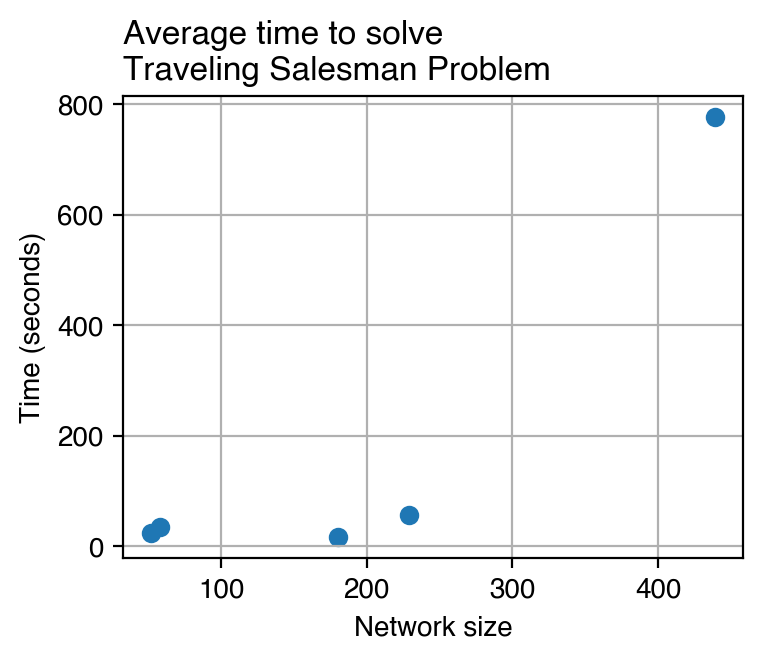

In [29]:
fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(df_tsp['N'], df_tsp['time_mean'])
ax.set_title("Average time to solve\nTraveling Salesman Problem", loc="left")
ax.set_xlabel("Network size")
ax.set_ylabel("Time (seconds)")
ax.grid(True)
plt.show()

In [30]:
fig.savefig("figure/fig_tsp_mean_acopy.pdf", bbox_inches='tight')

#### Plot time ditstribution by networks

In [31]:
import seaborn as sns

In [32]:
# Convert dictionary of time by networks to long table
times_long = []
for key, values in times.items():
    for value in values:
        times_long.append({'network': key, 'time': value})
df_time_long = pd.DataFrame(times_long)

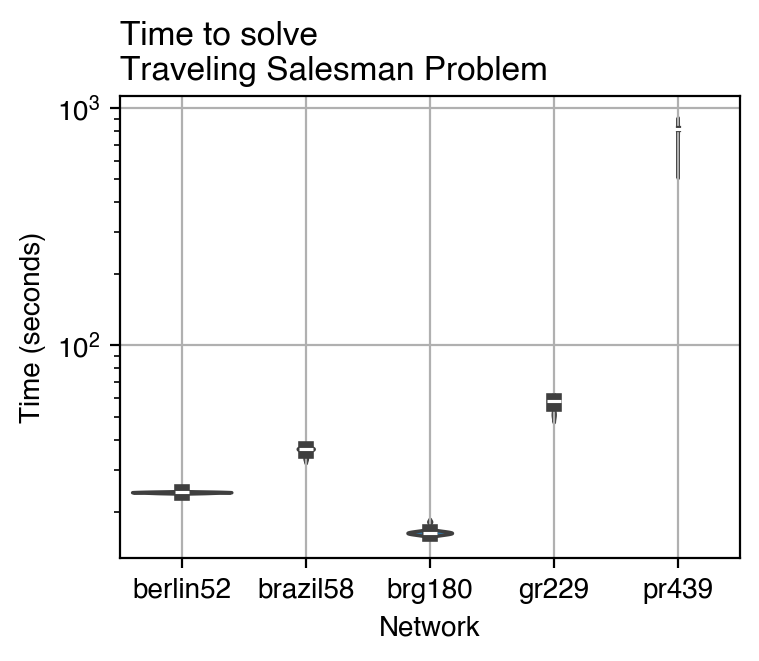

In [35]:
# Let's plot
fig, ax = plt.subplots(figsize=(4,3))
sns.violinplot(x='network', y='time', data=df_time_long)
ax.set_title('Time to solve\nTraveling Salesman Problem', loc="left")
ax.set_xlabel('Network')
ax.set_ylabel('Time (seconds)')
ax.set_yscale('log')
ax.grid()
plt.show()

### Appendix: Solving TSP by tspy
Non-complete codes. Tried solving using tspy but didn't perform well.

#### Convert network to cost matrix

In [429]:
import itertools

In [11]:
# Make empty matrix with the size of the nodes
N = graphs['berlin52'].number_of_nodes()
cost_matrix = np.zeros((N, N))

In [12]:
# Get cost of edges
cost_list = nx.get_edge_attributes(graphs['berlin52'], 'cost')

In [13]:
# Get node list (to be used to create cost matrix)
node_list = list(graphs['berlin52'].nodes())

In [14]:
# Get cost for all pairs of nodes
for node in itertools.permutations(node_list, 2):
    # Use node_list.index() because the node label is not necessarily the same as the index
    cost_matrix[node_list.index(node[0]), node_list.index(node[1])] = cost_list[node]

In [15]:
cost_matrix

array([[   0.        ,  666.10809934,  281.11385594, ...,  217.08293346,
         789.38267019, 1220.46097848],
       [ 666.10809934,    0.        ,  649.32657423, ...,  596.25917184,
        1421.55724471, 1716.04924172],
       [ 281.11385594,  649.32657423,    0.        , ...,  463.24939288,
         995.3140208 , 1483.59361012],
       ...,
       [ 217.08293346,  596.25917184,  463.24939288, ...,    0.        ,
         829.60834133, 1150.76061803],
       [ 789.38267019, 1421.55724471,  995.3140208 , ...,  829.60834133,
           0.        ,  624.81997407],
       [1220.46097848, 1716.04924172, 1483.59361012, ..., 1150.76061803,
         624.81997407,    0.        ]])

In [437]:
# Make it into a function
def make_cost_matrix_from_network(G, attribute_name='cost'):
    """
    Generate a cost matrix from a networkx graph object.

    Args:
        G (networkx.Graph): NetworkX graph object
        attribute_name (str): Name of the edge attribute to be used as the cost. Default is 'cost'.
    Returns:
        numpy.ndarray: A 2D numpy array representing the cost matrix of the graph.
                    The element at position (i, j) represents the cost of the edge
                    from node i to node j.
    """

    N = G.number_of_nodes()

    # Create empty matrix
    cost_matrix = np.zeros((N, N))

    # Get list of costs
    cost_list = nx.get_edge_attributes(G, attribute_name)

    # Get list of nodes
    node_list = list(G.nodes())
    for node in itertools.permutations(node_list, 2):
        # Get cost from edge attribute and put it in the matrix
        # Use node_list.index() because the node label is not necessarily the same as the index
        cost_matrix[node_list.index(node[0]), node_list.index(node[1])] = cost_list[node]
    
    return cost_matrix

In [17]:
# Let's check if the edge cost is converted to matrix correctly.
# Here's the cost for 0 -> 1
list(graphs['brazil58'].edges(data=True))[0]

('0', '1', {'cost': 2635.0})

In [18]:
# This provides the cost matrix for the brazil58 network
# The value of the (1, 2) component of the matrix, which is 0 -> 1 edge, matches with the original edge cost in the network (2635)
make_cost_matrix_from_network(graphs['brazil58'])

array([[   0., 2635., 2713., ..., 3870., 1417.,  739.],
       [2635.,    0.,  314., ..., 2072., 1196., 1517.],
       [2713.,  314.,    0., ..., 1882., 2699., 1557.],
       ...,
       [3870., 2072., 1882., ...,    0., 2328., 2986.],
       [1417., 1196., 2699., ..., 2328.,    0.,  962.],
       [ 739., 1517., 1557., ..., 2986.,  962.,    0.]])

#### Solve TSP
Here, we use [`tspy` package](https://github.com/wborgeaud/tspy/tree/master/tspy) to solve the traveling salesman problem.  
The algorithm used is 2-opt, where the source code can be found [here](https://github.com/wborgeaud/tspy/blob/master/tspy/solvers/twoopt.py).

In [19]:
# Not found in conda, so use PIP for this
# !pip install tspy

In [20]:
# cvxopt is required for tspy.lower_bounds
# !conda install cvxopt

In [201]:
from tspy import TSP
from tspy.solvers import TwoOpt_solver, NN_solver
from tspy.lower_bounds import Simple_LP_bound

In [251]:
def solve_TSP(cost_matrix, n_iter=1000, get_lower_bound=False):
    """
    Solves the Traveling Salesman Problem (TSP) using a 2-opt heuristic algorithm, for a given cost matrix.

    Args:
        cost_matrix (2d array): A 2D array of cost matrix where  cost_matrix[i][j] is the cost of traveling from node i to node j.
        n_iter (int): Number of iterations for the 2-opt algorithm. Default is 1000.
        get_lower_bound (bool): If True, the lower bound of the solution will be calculated. Default is False. Enabling this will increase the computation time.

    Returns:
        tuple: A tuple containing a list of nodes for the best path found by the algorithm and the lower bound of the solution.
            - opt_tour (list): A list of nodes for the best path found by the algorithm.
            - lower_bound (float): The lower bound of the solution. Returns None if get_lower_bound is False.
        : A list of nodes for the best path found by the algorithm.
    """

    tsp = TSP()
    tsp.read_data(cost_matrix)
    opt = TwoOpt_solver(initial_tour='NN', iter_num=n_iter)
    opt_tour = tsp.get_approx_solution(opt)
    if get_lower_bound:
        lower_bound = tsp.get_lower_bound(Simple_LP_bound())
    else:
        lower_bound = None

    # opt = NN_solver()
    # opt_tour = tsp.get_approx_solution(NN_opt)

    return opt_tour, lower_bound, tsp

In [252]:
best_tour, lower_bound, tsp = solve_TSP(cost_matrix)

The cost is 184153.5711719683.


In [254]:
from tspy.solvers.utils import get_cost

In [280]:
costs = {}
for key in graphs:
    graph = graphs[key]
    print("network: {}".format(key))
    cost_matrix = make_cost_matrix_from_network(graph)
    best_tour, lower_bound, tsp = solve_TSP(cost_matrix, n_iter=10000)
    cost = get_cost(best_tour, tsp)
    costs[key] = cost

network: berlin52
The cost is 38500.46012108622.
network: gr229
The cost is 1465081.898082222.
network: pr439
The cost is 1562678.3441748864.
network: brg180
The cost is 4249070.495987699.
network: brazil58
The cost is 184153.5711719683.


In [217]:
def has_passed_all_nodes(node_list, best_tour):
    """
    Checks if all nodes in the node_list have been passed in the best_tour.

    Args:
        node_list (list): A list of nodes in a graph. (`list( G.nodes() )` in networkx)
        best_tour (list): A list representing the best tour, containing index of nodes that has passed. Output from solve_TSP().
    
    Returns:
        bool: True if all nodes in the node_list have been passed in the best_tour, False otherwise.
    """

    N = len(node_list)
    passed_node_list = []
    for node in node_list:
        if node_list.index(node) in best_tour:
            passed_node_list.append(True)
        else:
            passed_node_list.append(False)

    # Check that all nodes are passed
    return sum(passed_node_list) == N

In [218]:
# Let's check that the best tour has passed all nodes
has_passed_all_nodes(node_list, best_tour)

True

#### Measure time

In [219]:
import time

In [247]:
def measure_time_to_solve_TSP(cost_matrix, num_rep=20):
    """
    Measures the time taken to solve the Traveling Salesman Problem (TSP) for a given cost matrix over multiple repetitions.

    Args:
        cost_matrix (2d array): A 2D array representing the cost matrix for the TSP.
        num_rep (int): The number of repetitions to measure the time. Default is 10.

    Returns:
        tuple: A tuple containing two lists:
            - time_list (list of float): A list of elapsed times for each repetition.
            - best_tour_list (list of list): A list of the best tour list found for each repetition.
            - lower_bound_list (list of float): A list of the lower bound of the solution for each repetition.
    """
    
    time_list = []
    best_tour_list = []
    lower_bound_list = []
    for _ in range(num_rep):

        start_time = time.time()

        best_tour, lower_bound = solve_TSP(cost_matrix)

        end_time = time.time()
        elapsed_time = end_time - start_time

        time_list.append(elapsed_time)
        best_tour_list.append(best_tour)
        lower_bound_list.append(lower_bound)
    
    return time_list, best_tour_list, lower_bound_list

In [223]:
# Repeat solving TSP for all networks, and measure the time
time_dict_by_network = {}

for f in file_list2:
    print(f)
    cost_matrix = make_cost_matrix_from_network(graphs[f])
    time_list, _, _ = measure_time_to_solve_TSP(cost_matrix, num_rep=20)
    time_dict_by_network[f] = time_list

berlin52
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
The cost is 38500.46012108622.
gr229
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.898082222.
The cost is 1465081.8980

In [227]:
# Let's summarize the time taken to solve TSP for each network
df_TSP_time = pd.DataFrame(time_dict_by_network)
df_TSP_time.describe()

,berlin52,gr229,pr439,brg180,brazil58
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.009627,0.824489,9.769609,0.289464,0.009951
std,0.005935,0.006939,0.114206,0.004637,0.000142
min,0.007961,0.818196,9.642843,0.284068,0.009756
25%,0.008026,0.821221,9.695719,0.285548,0.009830
50%,0.008150,0.822518,9.738823,0.288735,0.009920
75%,0.008359,0.825184,9.803167,0.291687,0.010074
max,0.034733,0.850853,10.100138,0.302348,0.010213


In [228]:
# Prepare a dictionary of mean time and network size for plot
N_dict = {}
time_mean_dict = {}

for f in file_list2:
    N = graphs[f].number_of_nodes()
    N_dict[f]  = N

    time_mean = np.mean(time_dict_by_network[f])
    time_mean_dict[f] = time_mean

time_mean_dict

{'berlin52': 0.009627211093902587,
 'gr229': 0.824489426612854,
 'pr439': 9.76960928440094,
 'brg180': 0.28946433067321775,
 'brazil58': 0.009950995445251465}

In [229]:
df_TSP_time_mean = pd.DataFrame([time_mean_dict, N_dict], index=["mean_time", "N"]).T
df_TSP_time_mean

,mean_time,N
berlin52,0.009627,52.0
gr229,0.824489,229.0
pr439,9.769609,439.0
brg180,0.289464,180.0
brazil58,0.009951,58.0


In [444]:
# Let's plot
fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(df_TSP_time_mean['N'], df_TSP_time_mean['mean_time'])
ax.set_title("Average time to solve\nTraveling Salesman Problem", loc="left")
ax.set_xlabel("Network size")
ax.set_ylabel("Time (seconds)")
ax.grid(True)

NameError: name 'df_TSP_time_mean' is not defined

In [232]:
fig.savefig("figure/fig_tsp_mean_tspy.pdf", bbox_inches='tight')